In [1]:
from __future__ import print_function, division
import thinkbayes
import thinkplot

import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from scipy.stats import norm




In [43]:
class Invest(thinkbayes.Suite):
    def Likelihood(self, data, hypo):
        """Computes the likelihood of the data under the hypothesis.
        hypo: integer value of x, the probability of heads (0-100)
        data: string 'H' or 'T'
        """
        p = hypo / 100.0
        if data == 'H':
            return p
        else:
            return 1-p


def AverageLikelihood(suite, data):
    total = 0
    for hypo, prob in suite.Items():
        like = suite.Likelihood(data, hypo)
        total += prob * like
    return total

def analyze(suite, evidence, theta_down=50, theta_up=75,herding='herding'):
    list_=[]
    actual=[]
    if herding=='herding':
        for outcome in evidence:
            #theta_start = AverageLikelihood(suite, outcome)
            theta_start = suite.MaximumLikelihood()
            ci= suite.CredibleInterval(90)
            list_.append([ci[0],ci[1], theta_start])
            if theta_start>theta_down and theta_start<theta_up:
                suite.Update(outcome)
                actual.append(outcome)
                #print("mid")
            elif theta_start>=theta_up:
                suite.Update('H')
                actual.append('H')
                #print("H")
            elif theta_start<=theta_down:
                suite.Update('T')
                actual.append('T')
                #print("T")
    elif herding=='wisdom':
        for outcome in evidence:
            theta_start = suite.MaximumLikelihood()
            ci= suite.CredibleInterval(90)
            list_.append([ci[0],ci[1], theta_start])
            suite.Update(outcome)
            actual.append(outcome)
    return list_, suite, actual

def plotme_one_graph_w_confidence_interval(data_h, data_w, theta_down, theta_up):
    # evenly sampled time at 1 intervals
    t = np.arange(1, data_h.shape[0]+1, 1)
    plt.plot(t,data_h[:,0], 'r--')
    plt.plot(t,data_h[:,1], 'r--') 
    herding_, =plt.plot(t,data_h[:,2], 'r', linewidth=5.0, label='Herding')     
    plt.plot(t,data_w[:,0], 'b--')
    plt.plot(t,data_w[:,1], 'b--') 
    wisdom_ = plt.plot(t,data_w[:,2], 'b', linewidth=5.0, label='Wisdom')
    plt.axhline(y=theta_down)
    plt.axhline(y=theta_up)
    plt.ylabel('The evolution of beliefts')
    plt.ylim((0,100))
    plt.legend()
    plt.show()

def triangular_prior(loc=50):
    suite = Invest()
    for x in range(0, loc+1):
        suite.Set(x, x)
    for x in range(loc+1, 101):
        #suite.Set(x, 100-x)
        suite.Set(x, loc/(100-loc)*(100-x))
    suite.Normalize()
    return suite

def gen_evidence(mean, sd, size=100, threshold_quality=75):
    r = norm.rvs(loc=mean, scale=sd, size=size)
    evidence=''
    for item in r:
        if item>=threshold_quality: 
            evidence +='H'
        else:
            evidence +='T'
    return evidence

def normal_prior(mean, sd):
    suite = Invest()
    for x in range(0,101):
        suite.Set(x, norm.pdf(x, loc=mean, scale=sd))
    suite.Normalize()
    return suite

def plot_aggregator(data_h, data_w, gamma, sigma):
    # evenly sampled time at 1 intervals
    t = np.arange(1, data_h.shape[0]+1, 1)
    plt.plot(t,data_h.mean(1), 'r', linewidth=5.0, label='Herding')     
    plt.plot(t,data_w.mean(1), 'b', linewidth=5.0, label='Wisdom')  # row axis is 1; column axis is 0. http://docs.scipy.org/doc/numpy/reference/generated/numpy.matrix.mean.html#numpy.matrix.mean
    theta_down= gamma-sigma
    theta_up= gamma+sigma
    plt.axhline(y=theta_down)
    plt.axhline(y=theta_up)
    plt.ylabel('The evolution of beliefts')
    plt.ylim((0,100))
    plt.legend()
    plt.show()


    

In [44]:
def result(mean, sd, steps=100, threshold_quality=75, gamma=50, sigma=25, locus_triangular= 50):
    
    #suite_h = Invest(range(0, 101))
    #suite_w = Invest(range(0, 101))
    #suite_prior = Invest(range(0, 101))
    
    #locus=locus_triangular
    #suite_h = triangular_prior(loc= locus)
    #suite_w = triangular_prior(loc= locus)
    #suite_prior = triangular_prior(loc= locus)
    suite_h = normal_prior(mean=mean, sd=sd)
    suite_w = normal_prior(mean=mean, sd=sd)
    suite_prior = normal_prior(mean=mean, sd=sd)
    #evidence = 'HTHHHTTHHH'*10
    #evidence = 'HTTTHTHHTHHT'*10
    evidence = gen_evidence(mean=mean,sd=sd,size=steps,threshold_quality= threshold_quality)
    theta_down= gamma-sigma
    theta_up= gamma+sigma
    list_info_h, suite_h, actual_h= analyze(suite_h, evidence, theta_down= theta_down, theta_up= theta_up,  herding='herding')
    list_info_w, suite_w, actual_w= analyze(suite_w, evidence,  herding='wisdom')
    # plotme_one_graph_w_confidence_interval(np.matrix(list_info_h) , np.matrix(list_info_w), theta_down, theta_up )
    return np.matrix(list_info_h), np.matrix(list_info_w)
    

def replicate_results(mean, sd, steps=100, threshold_quality=75, gamma=50, sigma=25, locus_triangular= 50, repeat=100):
    aggregator_h = np.matrix(np.zeros(shape=(steps,repeat)))
    aggregator_w = np.matrix(np.zeros(shape=(steps,repeat)))
    for t in range(repeat):
        data_h, data_w=result(mean = mean, sd= sd, steps=steps, threshold_quality=threshold_quality, gamma=gamma, sigma=sigma)
        aggregator_h[:,t]= data_h[:,2]
        aggregator_w[:,t]= data_w[:,2]
    return plot_aggregator(aggregator_h, aggregator_w, gamma, sigma)


# results


### first case: prior success increases the mean of private beliefs (drawn from normal distribution) in both (a) herding and (b) wisdom of crowd. (mean variable)

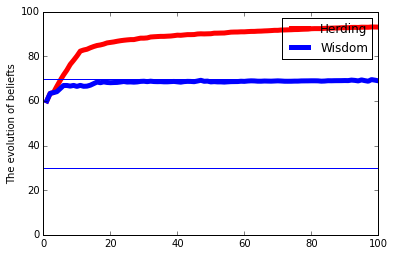

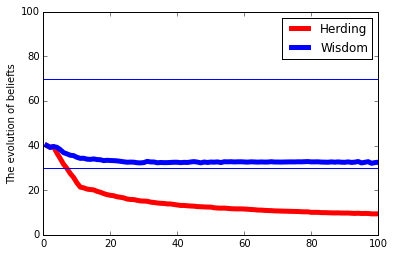

In [50]:
# (gamma - sigma, gamma + sigma) is the complement of cascade set.

replicate_results(mean = 60, sd= 20, steps=100, threshold_quality=50, gamma=50, sigma=20, repeat=100) 
replicate_results(mean = 40, sd= 20, steps=100, threshold_quality=50, gamma=50, sigma=20, repeat=100)



### Second case: prior success decreases the upper bound of beliefs (sigma +/- gamma) for a given quality project (sigma variable). It induces lager upward herding in general.

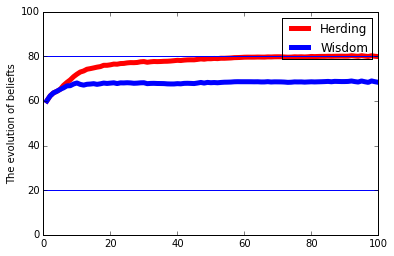

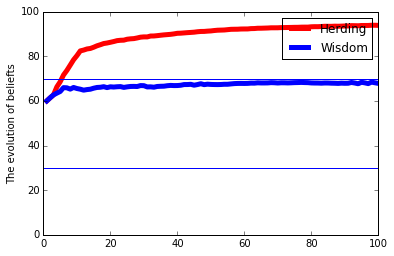

In [53]:
replicate_results(mean = 60, sd= 20, steps=100, threshold_quality=50, gamma=50, sigma=30, repeat=100)
replicate_results(mean = 60, sd= 20, steps=100, threshold_quality=50, gamma=50, sigma=20, repeat=100) 



###Third case: prior success lowers the threshold that a decision maker believes a project is investable. (threshold_quality variable)

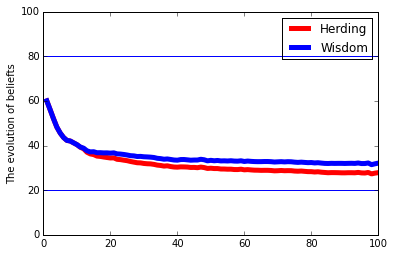

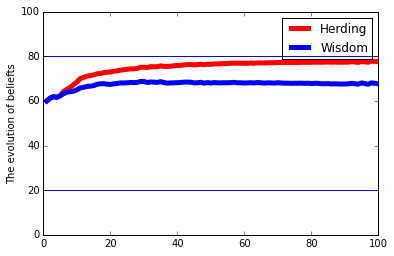

In [55]:
replicate_results(mean = 60, sd= 20, steps=100, threshold_quality=70, gamma=50, sigma=30, repeat=100) # with prior failure attempt
replicate_results(mean = 60, sd= 20, steps=100, threshold_quality=50, gamma=50, sigma=30, repeat=100) # with prior failure attempt